+ **목적** : 리뷰글의 긍정/부정 예측을 위한 모델 생성

+ **작성**
  + 데이터 불러오기
  + 

### 0.Import

In [1]:
# Colab에 Mecab 설치
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh

In [ ]:
# PyKoSpacing 설치
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
# from konlpy.tag import Mecab
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# wordcloud 준비
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)          


### 1.자료 불러오기 : 티몬 리뷰

In [9]:
##########
# 자료 불러오기
#####

from os import listdir

# 경로 설정
directory_name = "./tmon_data"

# 파일명 가져오기
file_names = listdir(directory_name)

tmon_data = pd.DataFrame()

# 전체 자료 불러오기 & 병합
for open_file in file_names:
    df_temp = pd.read_excel(directory_name +'/'+ open_file,'sheet1')
    tmon_data = pd.concat([tmon_data, df_temp], ignore_index=True)

In [10]:
# 주요 column만 추출
tmon_data = tmon_data[['TEXT', 'RANK']]
tmon_data.rename(columns = {'TEXT' : 'reviews', 'RANK' : 'ratings'}, inplace = True)

In [8]:
tmon_data.tail()

,reviews,ratings
3212,너무 마음에 듭니다. 추천합니다,5
3213,저렴히 구입했네요.\n잘 사용할게요~,5
3214,"딜뜰때 쟁여놔요, 쟁여놔요",5
3215,덕분에 폴바셋을 자주 가요. 감사^^,5
3216,좋아합니다좋아합니다,5


In [11]:
tmon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3217 entries, 0 to 3216
Data columns (total 2 columns):
reviews    3217 non-null object
ratings    3217 non-null int64
dtypes: int64(1), object(1)
memory usage: 50.3+ KB


In [14]:
tmon_data.columns

Index(['reviews', 'ratings'], dtype='object')

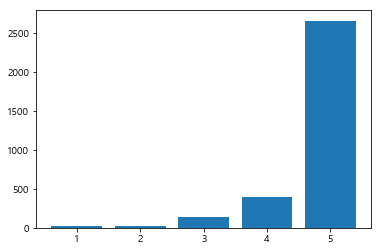

In [15]:
plt.bar(tmon_data.groupby(['ratings']).count().index, tmon_data.groupby(['ratings']).count()['reviews'])
plt.show()

### 2.데이터 전처리/Set 분류

In [16]:
##########
# 데이터 전처리
###

# 긍종/부정으로 나누기
tmon_data['label'] = np.select([tmon_data.ratings > 3], [1], default=0)

# 중복 제거
tmon_data['ratings'].nunique(), tmon_data['reviews'].nunique(), tmon_data['label'].nunique()
tmon_data.drop_duplicates(subset=['reviews'], inplace=True) 

# 공백값 제거
tmon_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
tmon_data = tmon_data.dropna(how='any') # Null 값 제거

# index 초기화
tmon_data = tmon_data.reset_index(drop=True)


In [17]:
print('총 샘플의 수 :',len(tmon_data))

총 샘플의 수 : 2845


In [18]:
from konlpy.tag import Okt
okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")
okt = Okt()

C:\Users\khpark\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [19]:
def tokenize(doc):
    #형태소와 품사를 join
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

In [35]:
# train_data['label'].value_counts().plot(kind = 'bar')
# plt.show()

In [20]:
##########
# train/test Set 분류
###
train_data, test_data = train_test_split(tmon_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 2133
테스트용 리뷰의 개수 : 712


In [21]:
test_data.values[:3]

array([['폴바셋 아이스크림을 너무 좋아해서 점심시간마다 후식으로 사먹는 임산부에요~~ㅋㅋ 11%할인하는 꿀딜에 저렴하게 구매해서 기분이 좋네요! 잘 쓸게요~ :)',
        5, 1],
       ['아메리카노만마시지만.. 아이스크림라떼가 최고!', 5, 1],
       ['기프트콘 합치는게 번거로워여', 3, 0]], dtype=object)

In [22]:
# 데이터 전처리 : tokenize
train_docs = [(tokenize(row[0]), row[2]) for row in train_data.values]
test_docs = [(tokenize(row[0]), row[2]) for row in test_data.values]

In [23]:
# tokenize 결과 확인
print(train_docs[0])
print(test_docs[0])

(['폴바/Noun', '셋/Noun', '라떼/Noun', '좋아하다/Adjective', '자주/Noun', '이용/Noun', '하다/Verb', '제품/Noun', '인데/Josa', '좋다/Adjective'], 1)
(['폴바/Noun', '셋/Noun', '아이스크림/Noun', '을/Josa', '너무/Adverb', '좋아하다/Adjective', '점심시간/Noun', '마다/Josa', '후식/Noun', '으로/Josa', '사먹다/Verb', '임산부/Noun', '에요/Josa', '~~/Punctuation', 'ㅋㅋ/KoreanParticle', '11%/Number', '할인/Noun', '하다/Verb', '꿀딜/Noun', '에/Josa', '저렴하다/Adjective', '구매/Noun', '하다/Verb', '기분/Noun', '이/Josa', '좋다/Adjective', '!/Punctuation', '자다/Verb', '쓸다/Verb', '~/Punctuation', ':)/Punctuation'], 1)


In [24]:
#토큰개수
tokens = [t for d in train_docs for t in d[0]]
print("토큰개수:", len(tokens))

토큰개수: 21265


In [28]:
#중복을 제외한 토큰개수
print("토큰개수(중복제외):", len(set(text.tokens)))

토큰개수(중보제외): 2007


In [36]:
import nltk
text = nltk.Text(tokens, name='NMSC')

#토큰개수
print("- 토큰개수:", len(text.tokens))

#중복을 제외한 토큰개수
print("- 토큰개수(중복제외):", len(set(text.tokens)))



- 토큰개수: 21265
- 토큰개수(중복제외): 2007
- 상위 토큰 10개 :  [('하다/Verb', 1141), ('좋다/Adjective', 1003), ('폴바/Noun', 657), ('셋/Noun', 643), ('./Punctuation', 583), ('자다/Verb', 493), ('\n/Foreign', 450), ('저렴하다/Adjective', 370), ('사용/Noun', 332), ('있다/Adjective', 329)]


In [53]:
#출력빈도가 높은 상위 토큰 10개
print("- 상위 토큰 10개 : ")
text.vocab().most_common(10)

- 상위 토큰 10개 : 


[('하다/Verb', 1141),
 ('좋다/Adjective', 1003),
 ('폴바/Noun', 657),
 ('셋/Noun', 643),
 ('./Punctuation', 583),
 ('자다/Verb', 493),
 ('\n/Foreign', 450),
 ('저렴하다/Adjective', 370),
 ('사용/Noun', 332),
 ('있다/Adjective', 329)]

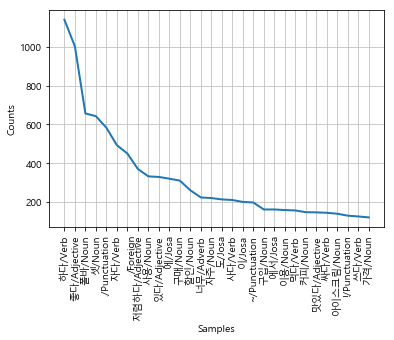

In [37]:
text.plot(30)

## 3.모델링 : vanilla

In [38]:
FREQUENCY_COUNT = 1000
selected_words = [f[0] for f in text.vocab().most_common(FREQUENCY_COUNT)]

In [55]:
selected_words[:3]

['하다/Verb', '좋다/Adjective', '폴바/Noun']

In [39]:
#단어리스트 문서에서 상위 10000개들중 포함되는 단어들이 개수
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

In [40]:
#문서에 들어가는 단어 개수
x_train = [term_frequency(d) for d,_ in train_docs]
x_test = [term_frequency(d) for d,_ in test_docs]

In [41]:
#라벨(1 or 0)
y_train = [c for _,c in train_docs]
y_test = [c for _,c in test_docs]

In [42]:
x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [58]:
x_train[:10]

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [59]:
y_train[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [64]:
import tensorflow as tf

#레이어 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(FREQUENCY_COUNT,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#학습 프로세스 설정
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.binary_accuracy])

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                64064     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 68,289
Trainable params: 68,289
Non-trainable params: 0
_________________________________________________________________


In [46]:
#학습 데이터로 학습
model.fit(x_train, y_train, epochs=20, batch_size=512)

Train on 2133 samples
Epoch 1/20
2133/2133 [==============================] - 1s 573us/sample - loss: 0.5918 - binary_accuracy: 0.8903
Epoch 2/20
2133/2133 [==============================] - 0s 31us/sample - loss: 0.4147 - binary_accuracy: 0.9480
Epoch 3/20
2133/2133 [==============================] - 0s 26us/sample - loss: 0.3085 - binary_accuracy: 0.9480
Epoch 4/20
2133/2133 [==============================] - 0s 25us/sample - loss: 0.2470 - binary_accuracy: 0.9480
Epoch 5/20
2133/2133 [==============================] - 0s 20us/sample - loss: 0.2121 - binary_accuracy: 0.9480
Epoch 6/20
2133/2133 [==============================] - 0s 21us/sample - loss: 0.1909 - binary_accuracy: 0.9480
Epoch 7/20
2133/2133 [==============================] - 0s 17us/sample - loss: 0.1760 - binary_accuracy: 0.9480
Epoch 8/20
2133/2133 [==============================] - 0s 17us/sample - loss: 0.1655 - binary_accuracy: 0.9480
Epoch 9/20
2133/2133 [==============================] - 0s 26us/sample - loss: 0.

In [47]:
results = model.evaluate(x_test, y_test)

712/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [48]:
results

[0.24122662568109088, 0.9578652]

In [60]:
def predict_review(review):
    token = tokenize(review)
    tfq = term_frequency(token)
    data = np.expand_dims(np.asarray(tfq).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        score_end,ratio = '긍정', round(score*100,4)
    else:
        score_end,ratio = '부정', round((1-score)*100,4)
    return score_end,ratio


In [61]:
for i in range(100,105):
    print(predict_review(tmon_data['reviews'][i]), tmon_data['label'][i])

('긍정', 98.2568) 1
('긍정', 98.6048) 1
('긍정', 98.8697) 1
('긍정', 66.2927) 0
('긍정', 98.8061) 1


In [193]:
tmon_data[104:105]

,reviews,ratings,label
104,저렴하게 구매해서 폴바셋 갔어요!,5,1


In [62]:
predict_review(tmon_data['reviews'][1445])

('긍정', 79.4841)

In [210]:
label_predict = []
for i in range(len(tmon_data)):
    token = tokenize(tmon_data['reviews'][i])
    tfq = term_frequency(token)
    data = np.expand_dims(np.asarray(tfq).astype('float32'), axis=0)
    score = float(model.predict(data))
    label_predict.append(score)

In [211]:
# i = 87
# (predict_review(tmon_data['reviews'][i]), tmon_data['label'][i])

# # tmon_data['reviews'][i]

In [214]:
tmon_data['label_gubun']=label_predict

In [217]:
tmon_data.tail(10)

,reviews,ratings,label,label_gubun
2835,상하농원에서도 폴바셋에서도 사용가능해서 너무 좋아요<,5,1,0.994226
2836,저렴하게 잘산것같아요,5,1,0.897668
2837,폴바셋 좋아하는데 구매했습니다. 자주 가야겠어요.,5,1,0.983445
2838,저렴해서 좋아요~\n딜 뜨면 늘 구매합니다~!,5,1,0.990581
2839,폴바셋 라떼는 진리입니다♡,4,1,0.974664
2840,너무 마음에 듭니다. 추천합니다,5,1,0.977839
2841,저렴히 구입했네요.\n잘 사용할게요~,5,1,0.983616
2842,"딜뜰때 쟁여놔요, 쟁여놔요",5,1,0.920764
2843,덕분에 폴바셋을 자주 가요. 감사^^,5,1,0.983239
2844,좋아합니다좋아합니다,5,1,0.909406


In [ ]:
model = tf.keras.models.Sequential([

In [71]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model2 = tf.keras.models.Sequential()
model2.add(Embedding(FREQUENCY_COUNT, 100))
model2.add(GRU(128))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('201019_model_1DCNN.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [72]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         100000    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               88320     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 188,449
Trainable params: 188,449
Non-trainable params: 0
_________________________________________________________________


In [73]:
history = model2.fit(x_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Train on 1706 samples, validate on 427 samples
Epoch 1/15
1680/1706 [============================>.] - ETA: 3s - loss: 0.2556 - acc: 0.9190 
Epoch 00001: val_acc improved from -inf to 0.95082, saving model to 201019_model_1DCNN.h5
1706/1706 [==============================] - 237s 139ms/sample - loss: 0.2559 - acc: 0.9191 - val_loss: 0.2038 - val_acc: 0.9508
Epoch 2/15
1680/1706 [============================>.] - ETA: 3s - loss: 0.2140 - acc: 0.9470 
Epoch 00002: val_acc did not improve from 0.95082
1706/1706 [==============================] - 231s 135ms/sample - loss: 0.2132 - acc: 0.9472 - val_loss: 0.1972 - val_acc: 0.9508
Epoch 3/15
1680/1706 [============================>.] - ETA: 3s - loss: 0.2124 - acc: 0.9470 
Epoch 00003: val_acc did not improve from 0.95082
1706/1706 [==============================] - 232s 136ms/sample - loss: 0.2118 - acc: 0.9472 - val_loss: 0.1962 - val_acc: 0.9508
Epoch 4/15
1680/1706 [============================>.] - ETA: 3s - loss: 0.2146 - acc: 0.9464 


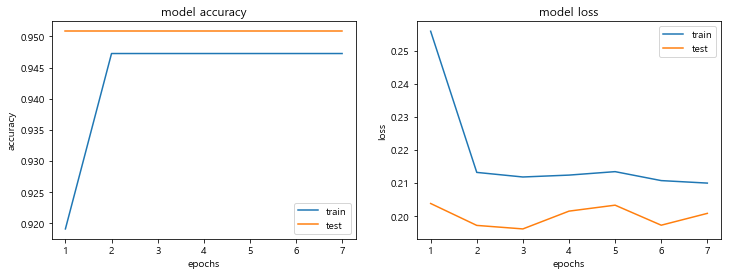

In [76]:
# 5. model evalustion : v1
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### 3.데이터 정제/토큰화

In [11]:
# 정규 표현식 수행 : train
train_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

# Null 값 제거 : train
train_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train_data = train_data.dropna(how='any') # Null 값 제거

# 정규 표현식 수행 : test
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

# Null 값 제거 : test
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [12]:
print('전처리 후 훈련 샘플의 개수 :',len(train_data))
print('전처리 후 테스트 샘플의 개수 :',len(test_data))

전처리 후 훈련 샘플의 개수 : 428991
전처리 후 테스트 샘플의 개수 : 142998


In [13]:
%%time

okt = Okt()

# token화
# mecab = Mecab()
# print(okt.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '요', '로', '하고', '으로']

# token화 : train
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

# token화 : test
test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

C:\ProgramData\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


Wall time: 24min 14s


### 4.단어와 길이 분포 확인하기 

In [14]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [15]:
negative_word_count = Counter(negative_words)
positive_word_count = Counter(positive_words)

print(negative_word_count.most_common(10))
print(positive_word_count.most_common(10))

[('너무', 13962), ('안', 12243), ('배송', 11812), ('잘', 9717), ('그냥', 9033), ('맛', 6494), ('했는데', 6099), ('별로', 5797), ('좀', 5689), ('제품', 5642)]
[('잘', 79612), ('좋아요', 69374), ('배송', 67072), ('맛', 50372), ('우유', 35844), ('구매', 34531), ('주문', 29528), ('너무', 26114), ('맛있어요', 24294), ('유통', 24219)]


In [16]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [17]:
# negative_word_count.most_common(20)

### 5.정수 인코딩 

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 122768
등장 빈도가 1번 이하인 희귀 단어의 수: 68031
단어 집합에서 희귀 단어의 비율: 55.41427733611365
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5342629737246387


In [19]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 54739


In [20]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 6.패딩 : 샘플들의 길이를 동일하게 맞춰주는 작업

리뷰의 최대 길이 : 1543
리뷰의 평균 길이 : 10.336151574275451


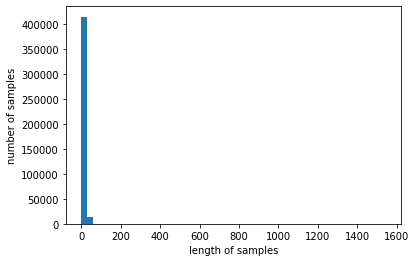

In [21]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [23]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.96643286222789


In [24]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 7.모델링 : 1D CNN
 + Activation : sigmoid
 + Optimizer : RMSprop
 + Metrics : binary_crossentropy

In [29]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5473900   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 5,562,349
Trainable params: 5,562,349
Non-trainable params: 0
_________________________________________________________________


In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('201019_model_1DCNN.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [33]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
5720/5720 [==============================] - ETA: 0s - loss: 0.2016 - acc: 0.9317
Epoch 00001: val_acc improved from -inf to 0.93864, saving model to 201019_model_1DCNN.h5
5720/5720 [==============================] - 856s 150ms/step - loss: 0.2016 - acc: 0.9317 - val_loss: 0.1876 - val_acc: 0.9386
Epoch 2/15
5720/5720 [==============================] - ETA: 0s - loss: 0.1763 - acc: 0.9432
Epoch 00002: val_acc improved from 0.93864 to 0.94120, saving model to 201019_model_1DCNN.h5
5720/5720 [==============================] - 852s 149ms/step - loss: 0.1763 - acc: 0.9432 - val_loss: 0.1805 - val_acc: 0.9412
Epoch 3/15
5720/5720 [==============================] - ETA: 0s - loss: 0.1674 - acc: 0.9473
Epoch 00003: val_acc improved from 0.94120 to 0.94254, saving model to 201019_model_1DCNN.h5
5720/5720 [==============================] - 917s 160ms/step - loss: 0.1674 - acc: 0.9473 - val_loss: 0.1763 - val_acc: 0.9425
Epoch 4/15
5720/5720 [==============================] - ETA: 0s 

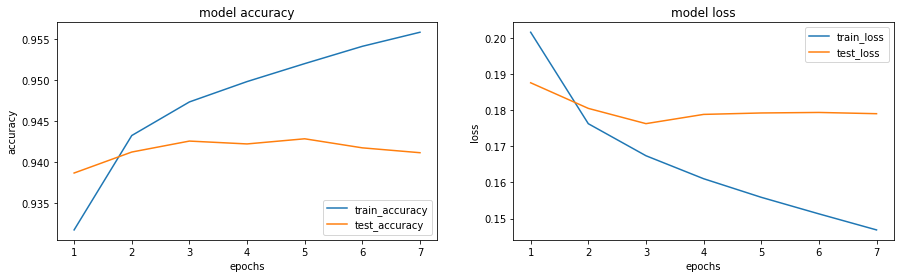

In [34]:
# 5. model evalustion : v1
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'test_accuracy'], loc='lower right')

plt.subplot(1,2,2)
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

In [ ]:
# history.save('best_model_1DCNN.h5')

### 8.모델링 : biLSTM

In [46]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [47]:
import graphviz 

In [48]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [49]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5489800   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 5,650,801
Trainable params: 5,650,801
Non-trainable params: 0
_________________________________________________________________


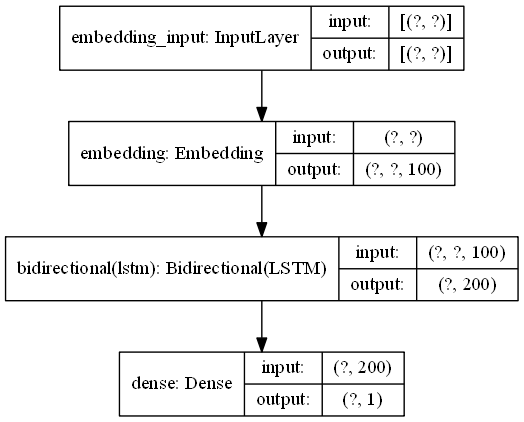

In [65]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

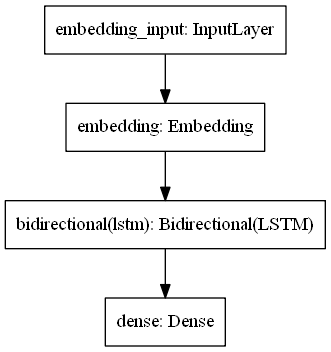

In [66]:
plot_model(model)

In [52]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('201020_model_biLSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [53]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model2_hist = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Train on 353925 samples, validate on 88482 samples
Epoch 1/15
353792/353925 [============================>.] - ETA: 0s - loss: 0.2049 - acc: 0.9304
Epoch 00001: val_acc improved from -inf to 0.93870, saving model to 201020_model_biLSTM.h5
353925/353925 [==============================] - 2247s 6ms/sample - loss: 0.2048 - acc: 0.9304 - val_loss: 0.1864 - val_acc: 0.9387
Epoch 2/15
353792/353925 [============================>.] - ETA: 0s - loss: 0.1749 - acc: 0.9437
Epoch 00002: val_acc improved from 0.93870 to 0.94260, saving model to 201020_model_biLSTM.h5
353925/353925 [==============================] - 1876s 5ms/sample - loss: 0.1749 - acc: 0.9437 - val_loss: 0.1772 - val_acc: 0.9426
Epoch 3/15
353792/353925 [============================>.] - ETA: 0s - loss: 0.1651 - acc: 0.9480
Epoch 00003: val_acc improved from 0.94260 to 0.94365, saving model to 201020_model_biLSTM.h5
353925/353925 [==============================] - 1807s 5ms/sample - loss: 0.1651 - acc: 0.9480 - val_loss: 0.1747 -

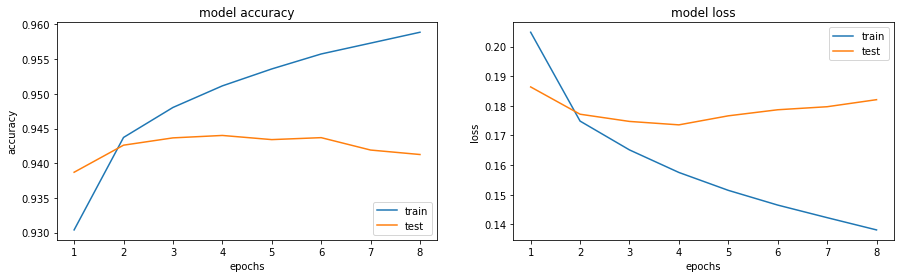

In [54]:
# 5. model evalustion : v1
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
epochs = range(1, len(model2_hist.history['acc']) + 1)
plt.plot(epochs, model2_hist.history['acc'])
plt.plot(epochs, model2_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
epochs = range(1, len(model2_hist.history['loss']) + 1)
plt.plot(epochs, model2_hist.history['loss'])
plt.plot(epochs, model2_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### 8.모델링 : biLSTM

In [25]:
import tensorflow_hub as hub

In [26]:
# import tensorflow_hub as hub
import tensorflow as tf
from keras import backend as K
import urllib.request
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [27]:
from keras.models import Model
from keras.layers import Dense, Lambda, Input

input_text = Input(shape=(1,), dtype=tf.string)
embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
hidden_layer = Dense(256, activation='relu')(embedding_layer)
output_layer = Dense(1, activation='sigmoid')(hidden_layer)
model = Model(inputs=[input_text], outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

RuntimeError: It looks like you are trying to use a version of multi-backend Keras that does not support TensorFlow 2.0. We recommend using `tf.keras`, or alternatively, downgrading to TensorFlow 1.14.

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

NameError: name 'Sequential' is not defined

### 9.결과평가

In [35]:
# test
test_sentense = '늘주문하는거라 잘먹는데요\n오늘도착예정이라는 말도없이 도착했다는말도없이 문앞에 두고가셨네요\n이건 냉장제품인데 아무리 아이스박스에 담아뒀다해도 냉매 다녹았던데 왜 연락이없으신건지 이러다 상하면 애기. 어찌먹이나요\n제가 아기재우고 10시반에나가니 문앞에 있는거보고 좀어이없어서'
test_sentense = test_sentense.replace("\n", " ")

loaded_model = load_model('201019_model_1DCNN.h5')

def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.(score : {})".format(score * 100, score))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.(score : {})".format((1 - score) * 100, score))

In [36]:
# sentiment_predict(test_sentense)

98.89% 확률로 부정 리뷰입니다.(score : 0.011074423789978027)


In [69]:
i = 15500
text, scroe = total_data2['reviews'][i], total_data2['ratings'][i]
print('원문 : {}\n'.format(text))
sentiment_predict(text)

원문 : 배송 암청 빠릅니다

86.89% 확률로 긍정 리뷰입니다.(score : 0.8689199090003967)


In [51]:
score_list = [] 
for i in range(1500):
    text, scroe = total_data2['reviews'][i], total_data2['ratings'][i]
    new_sentence = okt.morphs(text) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score_list.append(float(loaded_model.predict(pad_new))) # 예측


In [68]:
total_data2['reviews'][15500]

'배송 암청 빠릅니다'

In [56]:
new_sentence

['떨어지기', '전', '구매', '하는', '상품', '임다']

In [58]:
encoded

[[2049, 150, 7, 123, 70, 6242]]

In [59]:
pad_new

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 2049,  150,    7,
         123,   70, 6242]])

In [52]:
# score_list

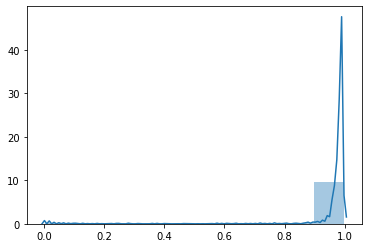

In [54]:
import seaborn as sns
sns.distplot(score_list, bins =10)
plt.show()

In [35]:
df2 = pd.read_excel('./20200923_NAVER_REVIEW_INFO.xlsx','Sheet1')

In [36]:
df2.tail()

,NAME,REVIEW,REVIEW_SCORE
431425,[매일유업] 바리스타룰스 코스타리카 330ml 12팩,연하지 않고 딱 좋네요,5
431426,[매일유업] 바리스타룰스 코스타리카 330ml 12팩,빠른 배송 감사합니다.,5
431427,[매일유업] 바리스타룰스 코스타리카 330ml 12팩,잘마시겠습니다 좋아요,4
431428,[매일유업] 바리스타룰스 코스타리카 330ml 12팩,발송 늦는다고 하셨는데 그렇게 안늦었네요,5
431429,[매일유업] 바리스타룰스 코스타리카 330ml 12팩,빠른배송 좋아요,5


In [62]:
df2['predict_biLSTM'] = 0

In [63]:
from datetime import date, time, datetime

loaded_model_biLSTM = load_model('201019_model_1DCNN.h5')
# predict_score = []

for i in range(len(df2['REVIEW'])):
    new_sentence = okt.morphs(df2['REVIEW'][i])                               # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence])                    # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len)                        # 패딩
    df2['predict_biLSTM'][i] = float(loaded_model_biLSTM.predict(pad_new))    # 예측
    if i % 1000 == 0:
        print('{} 번째 자료까지 예측 완료! (진행율 : {}% / {})'.format(i, round(i/len(df2['REVIEW'])*100,3),  str(datetime.now())) )


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0 번째 자료까지 예측 완료! (진행율 : 0.0% / 2020-10-19 13:22:07.855222)
1000 번째 자료까지 예측 완료! (진행율 : 0.2% / 2020-10-19 13:24:59.352651)
2000 번째 자료까지 예측 완료! (진행율 : 0.5% / 2020-10-19 13:30:19.274690)
3000 번째 자료까지 예측 완료! (진행율 : 0.7000000000000001% / 2020-10-19 13:32:20.364262)
4000 번째 자료까지 예측 완료! (진행율 : 0.8999999999999999% / 2020-10-19 13:34:03.742988)
5000 번째 자료까지 예측 완료! (진행율 : 1.2% / 2020-10-19 13:40:19.855041)
6000 번째 자료까지 예측 완료! (진행율 : 1.4000000000000001% / 2020-10-19 13:42:14.231386)
7000 번째 자료까지 예측 완료! (진행율 : 1.6% / 2020-10-19 13:44:24.627130)
8000 번째 자료까지 예측 완료! (진행율 : 1.9% / 2020-10-19 13:46:15.020573)
9000 번째 자료까지 예측 완료! (진행율 : 2.1% / 2020-10-19 13:57:14.760995)
10000 번째 자료까지 예측 완료! (진행율 : 2.3% / 2020-10-19 13:59:32.061179)
11000 번째 자료까지 예측 완료! (진행율 : 2.5% / 2020-10-19 14:02:24.991931)
12000 번째 자료까지 예측 완료! (진행율 : 2.8000000000000003% / 2020-10-19 14:07:20.356814)
13000 번째 자료까지 예측 완료! (진행율 : 3.0% / 2020-10-19 14:26:55.848239)
14000 번째 자료까지 예측 완료! (진행율 : 3.2% / 2020-10-19 14:28:26.537262)
15000 번째

ResourceExhaustedError:  OOM when allocating tensor with shape[42019,100] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node sequential/embedding/embedding_lookup/Read/ReadVariableOp (defined at C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_632287]

Function call stack:
distributed_function


In [123]:
df2.to_excel('20200923_NAVER_REVIEW_INFO_v2.xlsx', sheet_name= 'Sheet1' )